In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [2]:
sdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_4631_sw_2/'

savedir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_4631_sw_2/Spectra/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

fits_name = 'NGC_4631_sw_2.fits'

In [3]:
hdulist = fits.open(sdir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_4631_sw_2/NGC_4631_sw_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     311   ()      
  1  FLUX          1 ImageHDU        28   (53, 40, 47)   float64   
  2  ERROR         1 ImageHDU        28   (53, 40, 47)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (53, 40, 47)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (53, 40, 47)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (47,)   float64   
  6  X             1 ImageHDU         7   (53,)   float64   
  7  Y             1 ImageHDU         7   (40,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (47,)   float64   
  9  RESPONSE      1 ImageHDU         7   (47,)   float32   
 10  EXPOSURE_MAP    1 ImageHDU        28   (53, 40, 47)   int16   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU         8   (1341, 2)   float32   


In [4]:
hdulist[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                   53 /                                                
NAXIS2  =                   40 /                                                
NAXIS3  =                   47 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2019-05-10T09:06:35' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

In [5]:
wavelengths = hdulist[5].data

x_coords = hdulist[6].data
x_min = x_coords[0]
x_max = x_coords[len(x_coords)-1]

y_coords = hdulist[7].data
y_min = y_coords[0]
y_max = y_coords[len(y_coords)-1]

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[57.25034319 57.25832029 57.2662974  57.2742745  57.28225161 57.29022871
 57.29820581 57.30618292 57.31416002 57.32213713 57.33011423 57.33809134
 57.34606844 57.35404554 57.36202265 57.36999975 57.37797686 57.38595396
 57.39393106 57.40190817 57.40988527 57.41786238 57.42583948 57.43381658
 57.44179369 57.44977079 57.4577479  57.465725   57.4737021  57.48167921
 57.48965631 57.49763342 57.50561052 57.51358762 57.52156473 57.52954183
 57.53751894 57.54549604 57.55347315 57.56145025 57.56942735 57.57740446
 57.58538156 57.59335867 57.60133577 57.60931287 57.61728998]
0.0079771040646393


In [6]:
# wavelength is the first dimension
# y is the second dimension
# x is the third dimension

fluxmaps = hdulist[1].data

fluxmaps_min = np.nanmin(fluxmaps.flatten())
fluxmaps_max = np.nanmax(fluxmaps.flatten())

print(fluxmaps.shape)

(47, 40, 53)


In [7]:
def sum_spaxel(fluxmap, k_x, k_y):
    
    n_x = len(fluxmap[0])
    n_y = len(fluxmap)
    
    id_x = np.arange(np.floor((n_x-k_x)/2), np.floor((n_x-k_x)/2) + k_x, 1)
    id_x = id_x.astype(int)
    
    id_y = np.arange(np.floor((n_y-k_y)/2), np.floor((n_y-k_y)/2) + k_y, 1)
    id_y = id_y.astype(int)
    
    central_fluxmap = []
    
    for j in id_y:
        
        y_snip = []
        
        for i in id_x:
            
            y_snip.append(fluxmap[j][i])
            
        central_fluxmap.append(y_snip)
            
    central_fluxmap = np.array(central_fluxmap)
    
    central_flux = np.sum(central_fluxmap)
    
    return central_flux

In [8]:
central_fluxes_unfiltered = []

n_x = 5
n_y = 5

for fluxmap in fluxmaps:
    
    central_flux_unfiltered = sum_spaxel(fluxmap, n_x, n_y)
    central_fluxes_unfiltered.append(central_flux_unfiltered)
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

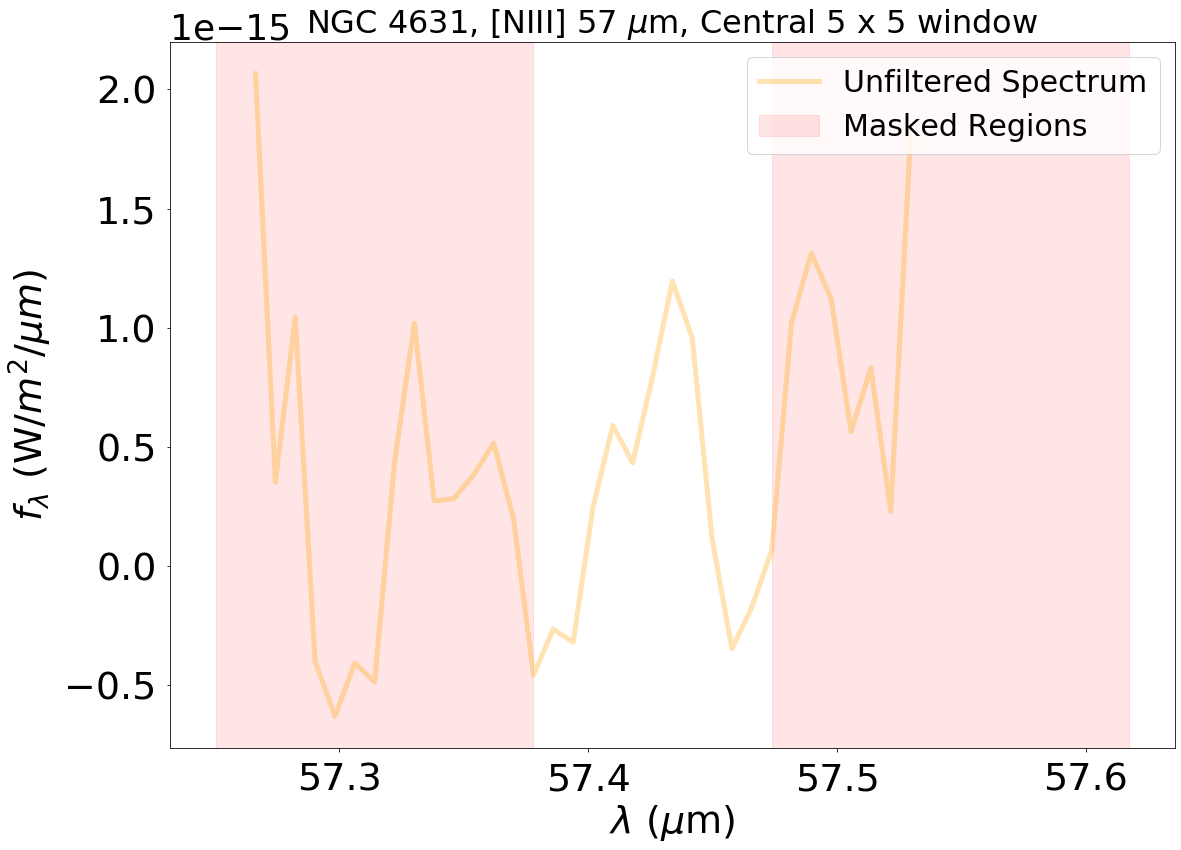

In [9]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[16], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[-19], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

plt.savefig(savedir + 'NGC_4631_[NIII]-1-unfiltered_spectrum.png'.format(str(n_x), str(n_y)))

ax.legend(prop={'size': 30}, loc = 'upper right')

In [10]:
print(central_fluxes_unfiltered)

[            nan             nan  2.06555582e-15  3.49856856e-16
  1.04355644e-15 -4.00112110e-16 -6.30441611e-16 -4.07745670e-16
 -4.87107850e-16  4.33018549e-16  1.01830974e-15  2.72922074e-16
  2.82523097e-16  3.83881470e-16  5.15653417e-16  1.97868945e-16
 -4.57931598e-16 -2.65545851e-16 -3.20123297e-16  2.46363502e-16
  5.89866636e-16  4.32433805e-16  7.93325665e-16  1.19509427e-15
  9.56986088e-16  1.14781136e-16 -3.47446128e-16 -1.73407027e-16
  6.38246636e-17  1.01931407e-15  1.31364948e-15  1.12083207e-15
  5.63991538e-16  8.31256781e-16  2.28457622e-16  1.80639586e-15
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan]


In [11]:
central_fluxes_filtered = central_fluxes_unfiltered
central_fluxes_filtered = central_fluxes_filtered[16:-18]

wavelengths_filtered = wavelengths[16:-18]

print(central_fluxes_filtered)

[-4.57931598e-16 -2.65545851e-16 -3.20123297e-16  2.46363502e-16
  5.89866636e-16  4.32433805e-16  7.93325665e-16  1.19509427e-15
  9.56986088e-16  1.14781136e-16 -3.47446128e-16 -1.73407027e-16
  6.38246636e-17]


In [12]:
central_fluxes_filtered_continuum = []

left_cut = 57.39
right_cut = 57.46

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[-4.57931598e-16 -2.65545851e-16             nan             nan
             nan             nan             nan             nan
             nan             nan             nan -1.73407027e-16
  6.38246636e-17]


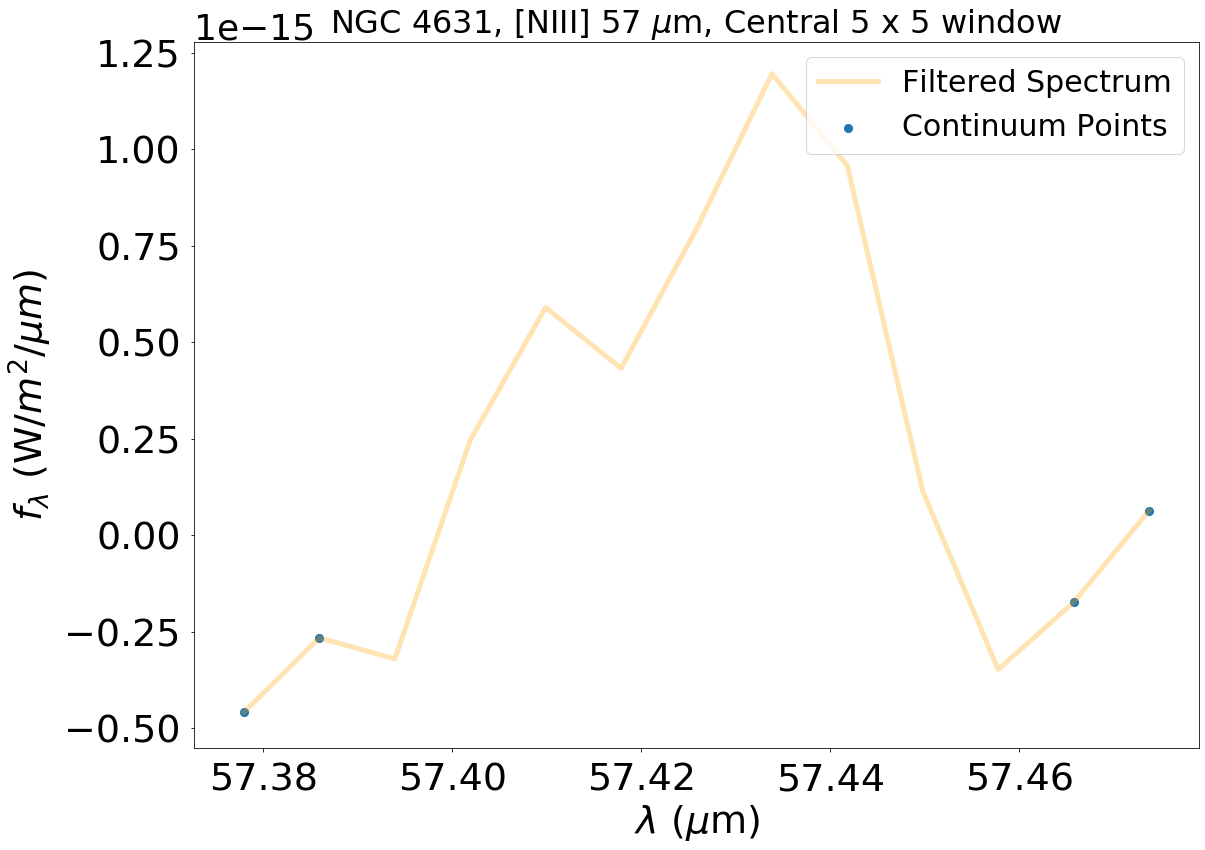

In [13]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_4631_[NIII]-2-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [14]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[ 3.69010171e-15 -2.12115453e-13]


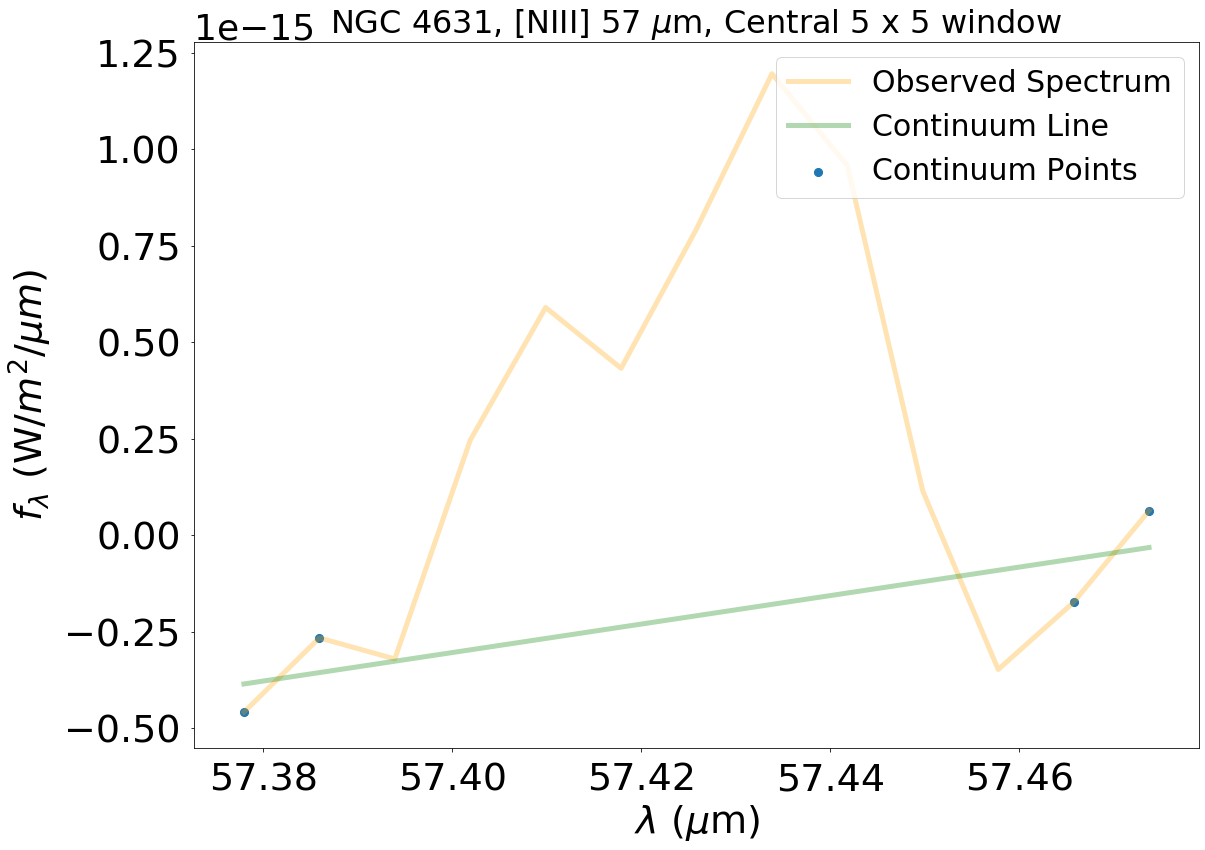

In [15]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_4631_[NIII]-3-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [16]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

[ 5.88695785e-18  5.42937431e-16  8.57004240e-16  6.70135084e-16
  1.00159062e-15  1.37392290e-15  1.10637839e-15  2.34737113e-16
 -2.56926476e-16]


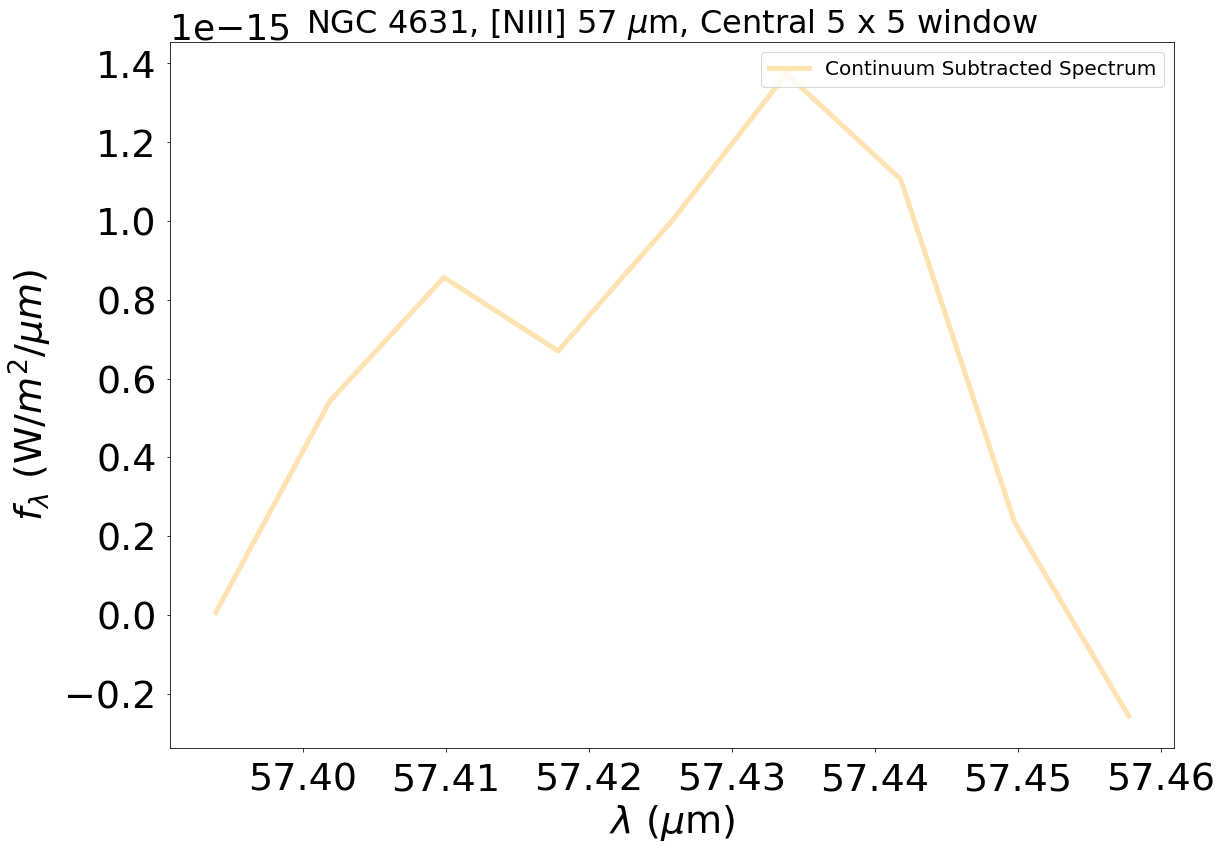

In [17]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_4631_[NIII]-4-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

print(central_fluxes_continuum_subtracted_act)

In [18]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [19]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(0, peak_ind):
    if(heights[i] >= peak_height/2):
        sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[1.2692323601704504e-15, 57.43381658409617, 0.013146150486146438]


[1.27249742e-17 1.59820137e-17 1.99569016e-17 2.47766032e-17
 3.05828142e-17 3.75318661e-17 4.57941393e-17 5.55528923e-17
 6.70024187e-17 8.03454554e-17 9.57897818e-17 1.13543972e-16
 1.33812293e-16 1.56788777e-16 1.82650542e-16 2.11550466e-16
 2.43609400e-16 2.78908099e-16 3.17479175e-16 3.59299316e-16
 4.04282152e-16 4.52272079e-16 5.03039419e-16 5.56277239e-16
 6.11600164e-16 6.68545434e-16 7.26576408e-16 7.85088631e-16
 8.43418486e-16 9.00854337e-16 9.56649973e-16 1.01004003e-15
 1.06025697e-15 1.10654917e-15 1.14819944e-15 1.18454340e-15
 1.21498706e-15 1.23902298e-15 1.25624429e-15 1.26635616e-15
 1.26918424e-15 1.26467956e-15 1.25292006e-15 1.23410826e-15
 1.20856547e-15 1.17672272e-15 1.13910859e-15 1.09633466e-15
 1.04907900e-15 9.98068328e-16 9.44059542e-16 8.87821236e-16
 8.30115843e-16 7.71682955e-16 7.13224320e-16 6.55390906e-16
 5.98772311e-16 5.43888704e-16 4.91185343e-16 4.41029653e-16
 3.93710696e-16 3.49440845e-16 3.08359372e-16 2.70537622e-16]


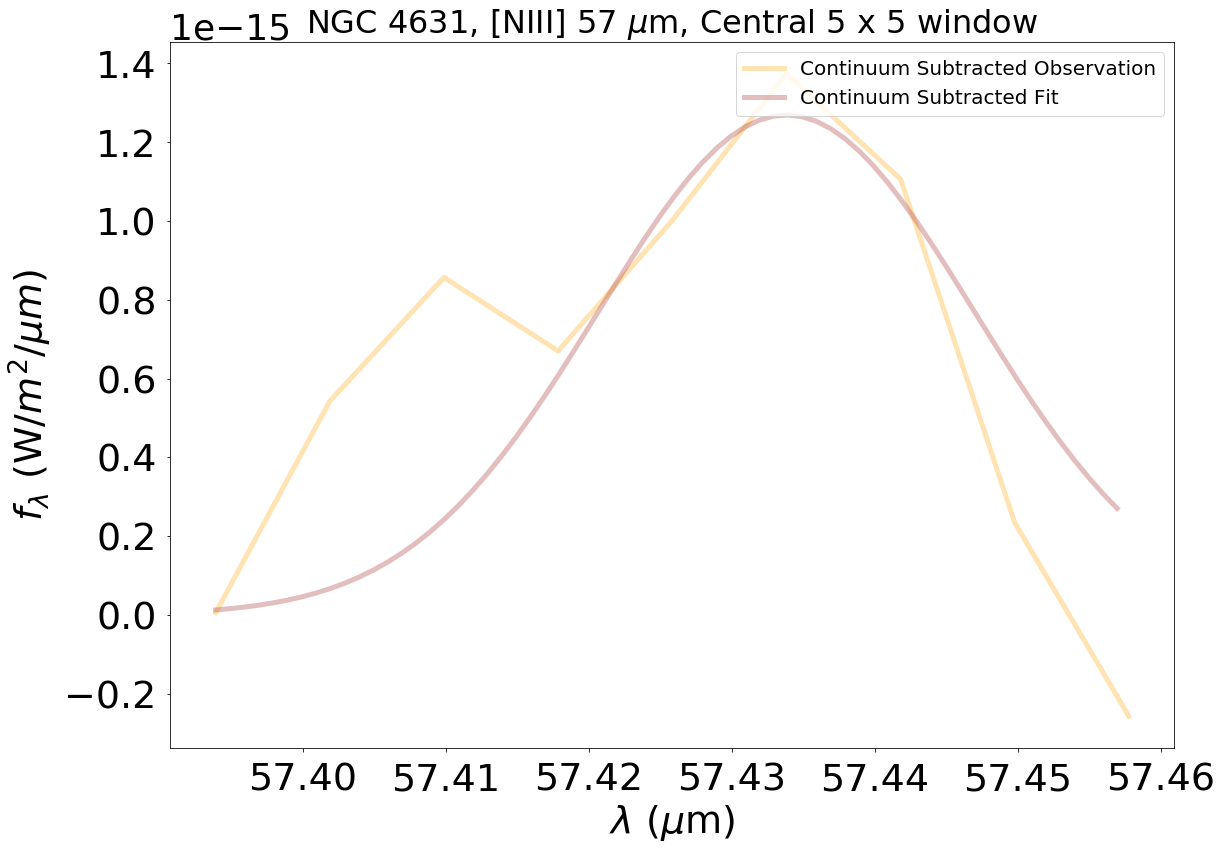

In [20]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_4631_[NIII]-5-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

[1.27249742e-17 1.59820137e-17 1.99569016e-17 2.47766032e-17
 3.05828142e-17 3.75318661e-17 4.57941393e-17 5.55528923e-17
 6.70024187e-17 8.03454554e-17 9.57897818e-17 1.13543972e-16
 1.33812293e-16 1.56788777e-16 1.82650542e-16 2.11550466e-16
 2.43609400e-16 2.78908099e-16 3.17479175e-16 3.59299316e-16
 4.04282152e-16 4.52272079e-16 5.03039419e-16 5.56277239e-16
 6.11600164e-16 6.68545434e-16 7.26576408e-16 7.85088631e-16
 8.43418486e-16 9.00854337e-16 9.56649973e-16 1.01004003e-15
 1.06025697e-15 1.10654917e-15 1.14819944e-15 1.18454340e-15
 1.21498706e-15 1.23902298e-15 1.25624429e-15 1.26635616e-15
 1.26918424e-15 1.26467956e-15 1.25292006e-15 1.23410826e-15
 1.20856547e-15 1.17672272e-15 1.13910859e-15 1.09633466e-15
 1.04907900e-15 9.98068328e-16 9.44059542e-16 8.87821236e-16
 8.30115843e-16 7.71682955e-16 7.13224320e-16 6.55390906e-16
 5.98772311e-16 5.43888704e-16 4.91185343e-16 4.41029653e-16
 3.93710696e-16 3.49440845e-16 3.08359372e-16 2.70537622e-16]


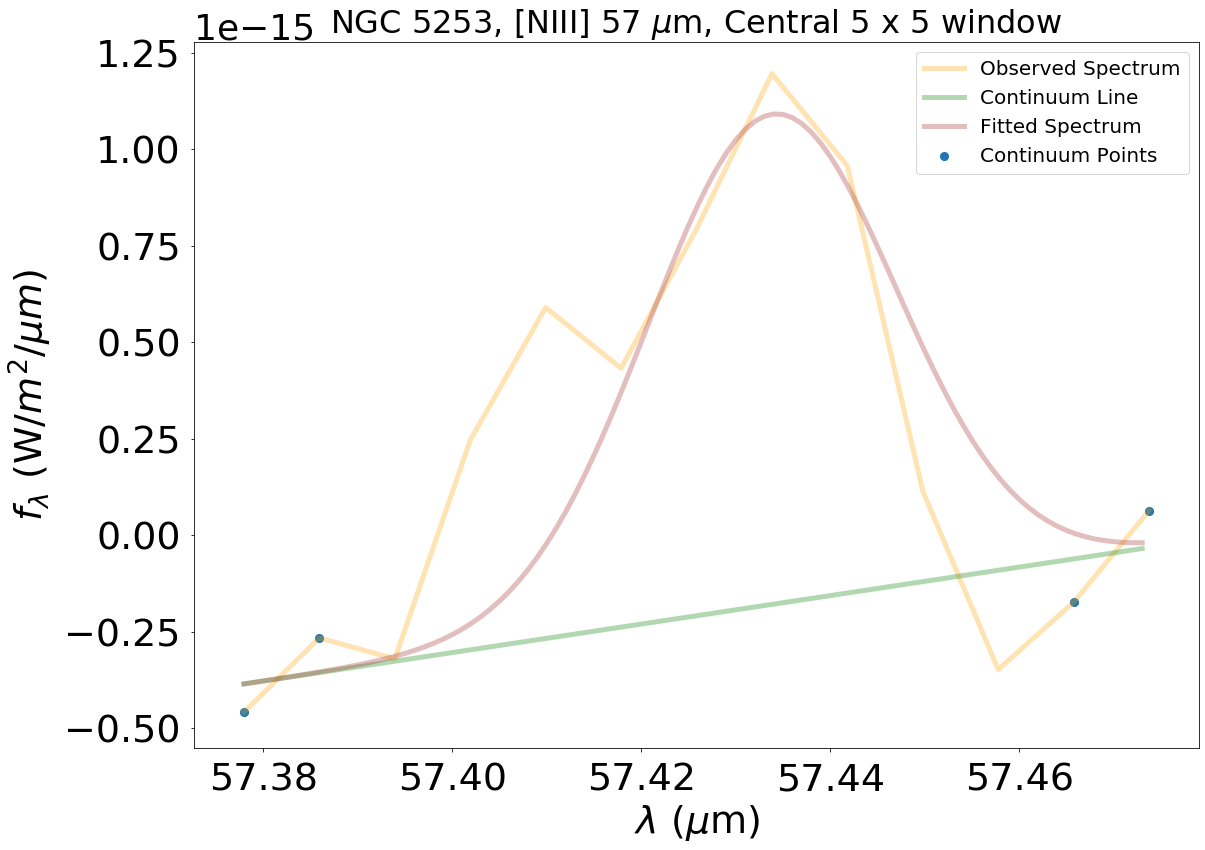

In [21]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]
fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_4631_[NIII]-6-final_spectrum.png'.format(str(n_x), str(n_y)))

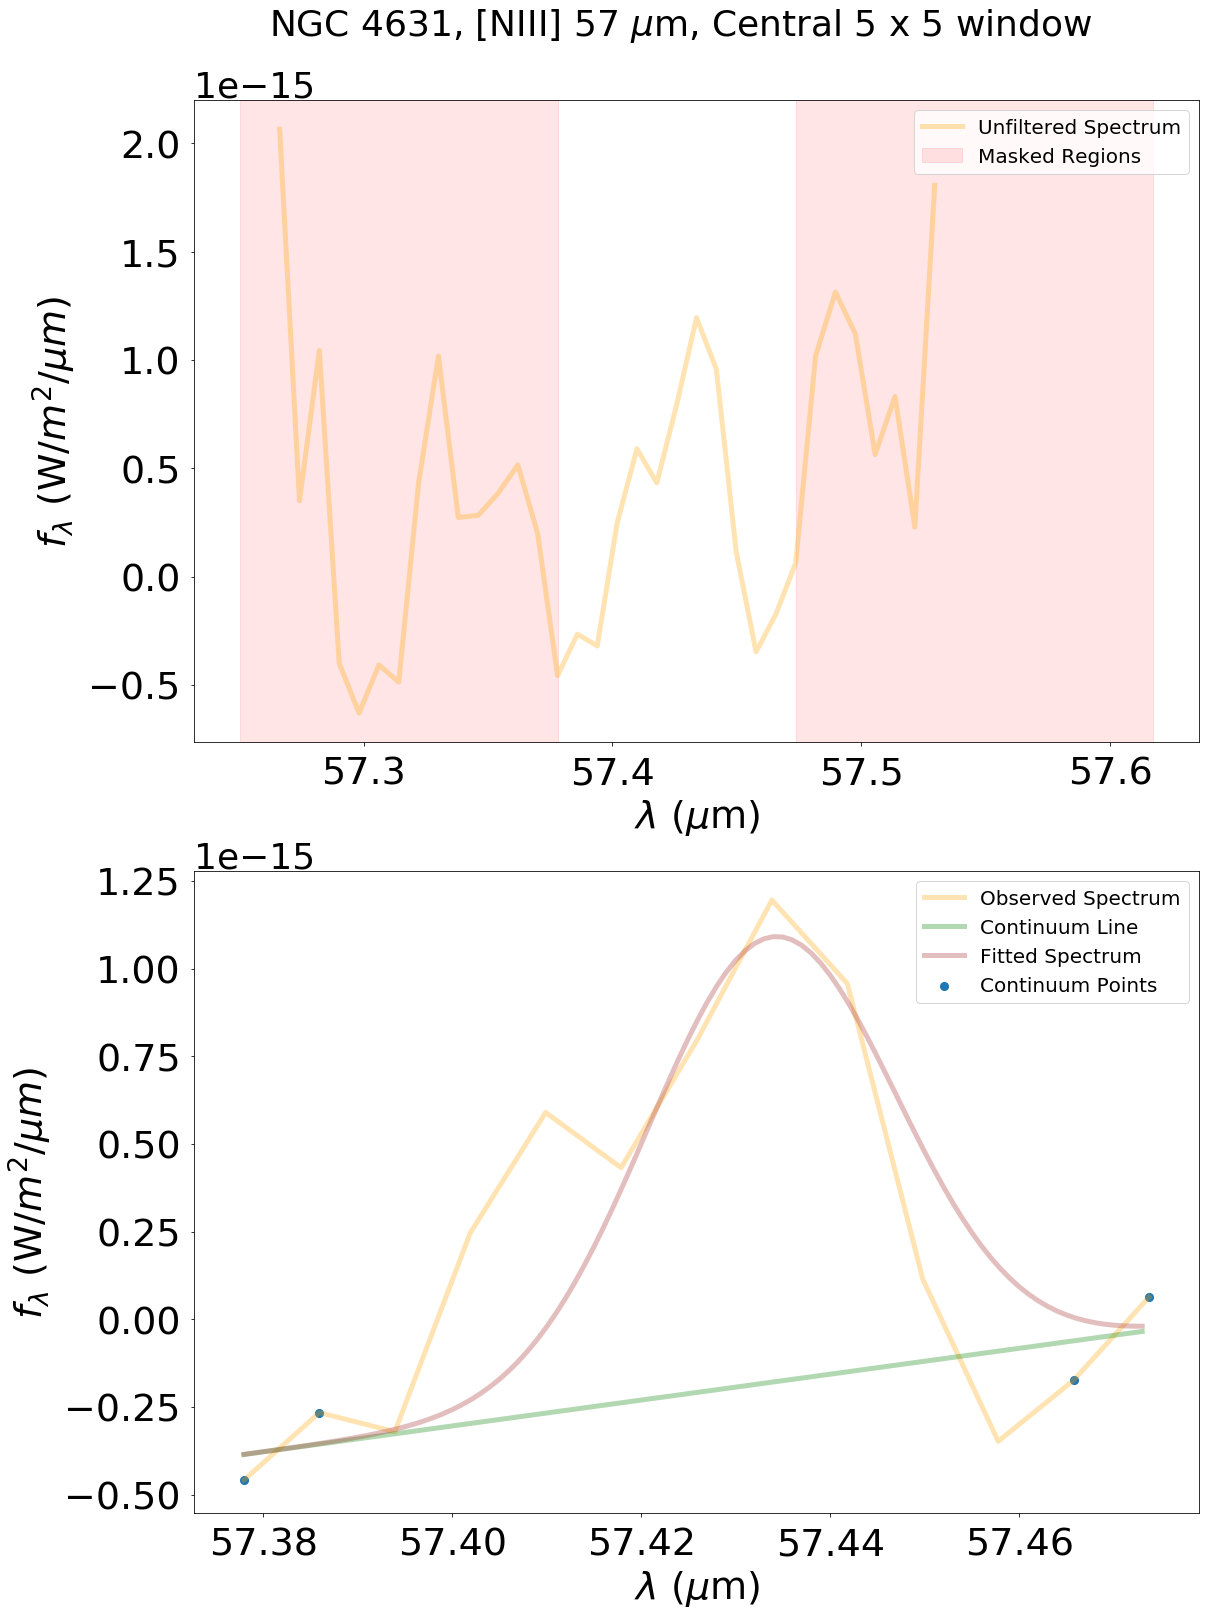

In [22]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[16], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[-19], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')

fig.suptitle(r'NGC 4631, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 36, y = 0.93)

plt.savefig(savedir + 'NGC_4631_[NIII]-7-summary_spectrum.png'.format(str(n_x), str(n_y)))

In [23]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum
print('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2')

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum
print('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2')

print('Spectral width = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')

Flux of the continuum subtracted observation = 4.4045228197461107e-17 W/m^2
Flux of the continuum subtracted fit = 4.1763147954450146e-17 W/m^2
Spectral width = 0.021889776412428452 microns
